In [1]:
# Imports
import os
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, AdamW
from sklearn.metrics import f1_score
from tqdm import tqdm


from google.colab import drive
drive.mount('/content/drive')
SAVE_PATH = '/content/drive/MyDrive/stance_detection_model'


import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/preprocessed_data_split/train_split.csv')
val_df = pd.read_csv('/content/drive/MyDrive/preprocessed_data_split/val_split.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:



tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_and_tokenize(data):
    data['cleaned_tweet'] = data['cleaned_tweet'].astype(str)
    inputs = tokenizer(
        list(data['cleaned_tweet']),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = torch.tensor(data['stance'].values, dtype=torch.long)
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    return DataLoader(dataset, batch_size=32, shuffle=True)

train_loader = preprocess_and_tokenize(train_df)
val_loader = preprocess_and_tokenize(val_df)




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:


class CustomBERTModel(torch.nn.Module):
    def __init__(self, num_labels):
        super(CustomBERTModel, self).__init__()
        from transformers import BertModel
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout1 = torch.nn.Dropout(0.1)
        self.fc1 = torch.nn.Linear(self.bert.config.hidden_size, 64)
        self.dropout2 = torch.nn.Dropout(0.1)
        self.fc2 = torch.nn.Linear(64, 32)
        self.dropout3 = torch.nn.Dropout(0.1)
        self.fc3 = torch.nn.Linear(32, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout1(outputs.pooler_output)
        x = torch.nn.ReLU()(self.fc1(x))
        x = self.dropout2(x)
        x = torch.nn.ReLU()(self.fc2(x))
        x = self.dropout3(x)
        return self.fc3(x)



In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERTModel(num_labels=3).to(device)

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
print(f"Using device: {device}")

Using device: cuda


In [12]:


def train_and_save_model(model, train_loader, val_loader, optimizer, criterion, epochs, save_path):
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch + 1} Training Loss: {train_loss / len(train_loader):.4f}")

       
        model.eval()
        val_loss, all_preds, all_labels = 0, [], []
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch + 1}"):
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Epoch {epoch + 1} Validation F1: {val_f1:.4f}, Loss: {val_loss / len(val_loader):.4f}")

       
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"{save_path}/model_weights.pth")
            tokenizer.save_pretrained(save_path)
            print(f"Model saved to {save_path} with F1: {best_f1:.4f}")


train_and_save_model(model, train_loader, val_loader, optimizer, criterion, epochs=3, save_path=SAVE_PATH)

Training Epoch 1: 100%|██████████| 694/694 [07:01<00:00,  1.64it/s]


Epoch 1 Training Loss: 0.5980


Validating Epoch 1: 100%|██████████| 174/174 [00:29<00:00,  5.89it/s]


Epoch 1 Validation F1: 0.7480, Loss: 0.5842
Model saved to /content/drive/MyDrive/stance_detection_model with F1: 0.7480


Training Epoch 2: 100%|██████████| 694/694 [07:01<00:00,  1.65it/s]


Epoch 2 Training Loss: 0.4670


Validating Epoch 2: 100%|██████████| 174/174 [00:29<00:00,  5.87it/s]


Epoch 2 Validation F1: 0.7719, Loss: 0.5781
Model saved to /content/drive/MyDrive/stance_detection_model with F1: 0.7719


Training Epoch 3: 100%|██████████| 694/694 [07:01<00:00,  1.65it/s]


Epoch 3 Training Loss: 0.3521


Validating Epoch 3: 100%|██████████| 174/174 [00:29<00:00,  5.88it/s]


Epoch 3 Validation F1: 0.7872, Loss: 0.6232
Model saved to /content/drive/MyDrive/stance_detection_model with F1: 0.7872


In [10]:
from transformers import BertTokenizer
import torch


model = CustomBERTModel(num_labels=3)  
model.load_state_dict(torch.load("/content/drive/MyDrive/stance_detection_model/model_weights.pth"))
model.to(device)
model.eval()


tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/stance_detection_model")
print("Model and tokenizer loaded successfully.")


<ipython-input-10-5617cf35fe68>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/stance_detection_model/model_weight

Model and tokenizer loaded successfully.


In [11]:

df = pd.read_parquet("/content/drive/MyDrive/preprocessed_data/merged_global_warming_tweets.parquet")


def preprocess_tweet(tweet):
    import re
    tweet = re.sub(r"http\S+|@\S+|#\S+", "", tweet)  
    tweet = re.sub(r"[^\w\s]", "", tweet)  
    return tweet.lower().strip()

df['cleaned_tweet'] = df['tweet'].apply(preprocess_tweet) 


inputs = tokenizer(
    list(df['cleaned_tweet']),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)


In [12]:
from torch.utils.data import DataLoader, TensorDataset


inference_dataset = TensorDataset(
    inputs['input_ids'],
    inputs['attention_mask']
)


inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)


In [13]:

all_predictions = []

model.eval()
with torch.no_grad():
    for batch in inference_loader:
        input_ids, attention_mask = [x.to(device) for x in batch]
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
        all_predictions.extend(batch_predictions)  


stance_mapping = {0: "Anti", 1: "Pro", 2: "Neutral"}
df['predicted_stance'] = [stance_mapping[pred] for pred in all_predictions]


df.to_csv("/content/drive/MyDrive/preprocessed_data/predicted_stances.csv", index=False)
print("Predictions saved to 'predicted_stances.csv'.")


Predictions saved to 'predicted_stances.csv'.


In [24]:
import pandas as pd


dff = pd.read_csv("/content/drive/MyDrive/preprocessed_data/predicted_stances.csv", on_bad_lines='skip', engine="python")
print(dff.head())  

          user                   id  \
0  RetirePedia  1203086131946041346   
1  RetirePedia  1158088972997931014   
2  RetirePedia  1140358200216182787   
3  RetirePedia  1107651714218369024   
4  RetirePedia  1043895529791533056   

                                               tweet  replies  retweets likes  \
0  .@TimmermansEU @vonderleyen Ich bin besorgt, d...      0.0       0.0     0   
1  Suffering from the current #heatwave? 😥 No Air...      0.0       0.0     0   
2  .@AngelMerkelCDU Als Europäer müssen wir voran...      0.0       0.0     0   
3  Hurricane season in Belize is typically from S...      0.0       0.0     0   
4  3 Places for a Beachfront #Retirement Outside ...      0.0       1.0     0   

  quotes                       date  \
0      0  2019-12-06T22:57:40+00:00   
1      0  2019-08-04T18:55:02+00:00   
2      0  2019-06-16T20:39:16+00:00   
3      0  2019-03-18T14:35:22+00:00   
4      0  2018-09-23T16:11:03+00:00   

                                       clea

In [25]:
import pandas as pd



dff = dff[dff['cleaned_tweet'].str.strip().astype(bool)]


updated_file_path = "/content/drive/MyDrive/preprocessed_data/updated_predicted_stances.csv"
dff.to_csv(updated_file_path, index=False)

print(f"Updated file saved to '{updated_file_path}'.")


Updated file saved to '/content/drive/MyDrive/preprocessed_data/updated_predicted_stances.csv'.


In [26]:
print(dff['predicted_stance'].value_counts())


predicted_stance
Pro        84391
Neutral    18770
Anti        1380
Name: count, dtype: int64


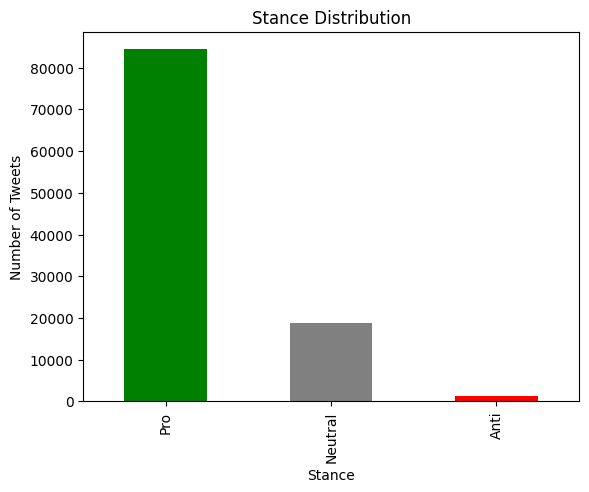

In [27]:
import matplotlib.pyplot as plt

stance_counts = dff['predicted_stance'].value_counts()
stance_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Stance Distribution")
plt.xlabel("Stance")
plt.ylabel("Number of Tweets")
plt.show()


In [29]:

dff['date'] = pd.to_datetime(dff['date'])


dff['year'] = dff['date'].dt.year


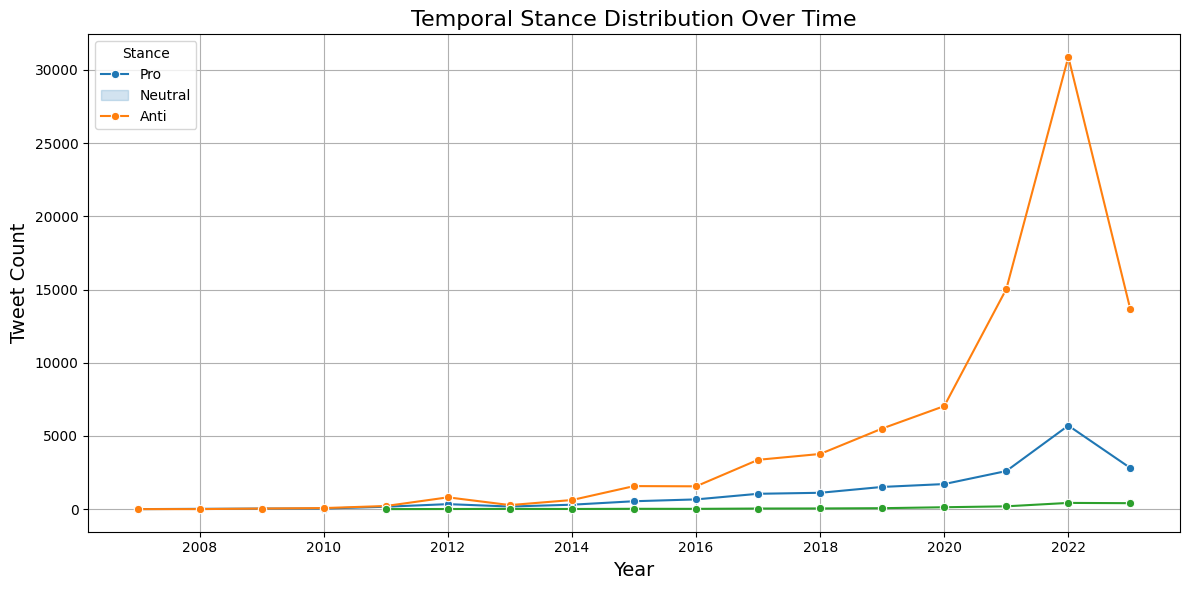

In [30]:

stance_by_year = dff.groupby(['year', 'predicted_stance']).size().reset_index(name='count')

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
sns.lineplot(data=stance_by_year, x='year', y='count', hue='predicted_stance', marker='o')

plt.title("Temporal Stance Distribution Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Tweet Count", fontsize=14)
plt.legend(title="Stance", labels=["Pro", "Neutral", "Anti"])
plt.grid(True)
plt.tight_layout()


plt.show()
